In [1]:
import os
import numpy as np

import megpy
import gyrokit
from gyrokit.utils import *

In [2]:
# settings
rho_fs = 0.95 # radial position in the 1D profiles and equilibrium, rho_tor_norm
use_fitted_q = False # True/False use the GPR fitted q-profile/use the numerical equilibrium q-profile

f_path = '../data/S069951_T01.pkl'
#f_path = './data/S069951_T01_cp.h5'
f_eq_path = '../data/S069951_T01_eq.h5'

In [3]:
# read EX2GK profile data
prof1d = gyrokit.CoreProfiles() # CoreProfiles objects store fitted profile data from EX2GK in core_profiles IDS format, see: https://gafusion.github.io/omas/schema/schema_core%20profiles.html
if '.pkl' in f_path:
    prof1d.read_ex2gk_pkl_to_ids(f_path)
elif '.h5' in f_path:
    prof1d.read_ids_core_profiles(f_path)

# get local profile values
prof1d.get_local_values1d(rho_fs)

Reading EX2GK pickle file to CoreProfiles...
Converting core_profile IDS 1D profiles to local values at rho_tor_norm = 0.95 ...


In [4]:
# get local magnetic geometry
eq = megpy.Equilibrium()
#eq.verbose = False
if '.pkl' in f_path:
    eq.read_ex2gk_pkl(f_path,use_fitted=use_fitted_q)
elif '.h5' in f_path:
    eq.read_ids_equilibrium(f_eq_path)
eq.add_derived(refine=4)

locgeo = megpy.LocalEquilibrium('miller',eq,rho_fs,
                                analytic_shape=True,
                                n_x=7,
                                n_harmonics=6,
                                n_theta='default',
                                opt_bpol=False,
                                opt_deriv=False,
                                verbose=True)

Reading EX2GK equilibrium information to Equilibrium...
Adding derived quantities to Equilibrium...
Adding fluxsurfaces to Equilibrium...
 100% completed
tracer time:0.071s / flux-surface
analytic extraction time:0.001s / flux-surface
Optimising parameterization fit of fluxsurfaces...
 100% completed
Optimization time:0.196s / flux-surface
Total fitting time:1.370s
Number of points on reference flux-surface: 678
Computing analytical Miller geometry quantities...


In [5]:
# reference units
m_e = 0.00027428995 # electron mass normalised to the mass of deuterium
z_e = -1.0

m_ref = 2.0 
n_ref = prof1d.local_values['electrons']['density_thermal']
T_ref = prof1d.local_values['electrons']['temperature']
L_ref = eq.derived['a'] # plasma minor radius at last closed flux-surface
c_s = 9.7871518E3*np.sqrt(T_ref/m_ref) # ion sound speed, prefactor is sqrt(1.602e-19/m_proton)

n_ions = len(prof1d.ids['profiles_1d[]&ion[]&density_thermal'])

In [6]:
tglf = gyrokit.TGLF()

# specify GACODE environment variables
tglf.metadata['gacode_platform'] = '"GFORTRAN_OSX_MACPORTS"'
tglf.metadata['gacode_root'] = '{}/Codes/gacode/'.format(os.path.expanduser('~'))

# specify TGLF run path
data_path = '../'
tglf.metadata['run_path'] = '{}/test/'.format(data_path)
tglf.collect = True

# units options: CGYRO, GENE
tglf.input['UNITS'] = 'CGYRO'

if tglf.input['UNITS'] == 'GENE':
    B_ref = locgeo.fs['Bref_miller']
else:
    B_ref = locgeo.fs['B_unit']
    #B_ref = locgeo.eq.derived['B_unit'][locgeo.x_grid.index(locgeo.x_loc)]

dxdr = locgeo.fs['dxdr'] # drho_tor_norm / dr w.r.t. the fitted r
#dxdr = np.gradient(locgeo.eq.fluxsurfaces['rho_tor'],locgeo.eq.fluxsurfaces['r'])[locgeo.x_grid.index(locgeo.x_loc)] # drho_tor_norm / dr w.r.t. the magnetic axis average r

# grid settings
tglf.input['NMODES'] = 4
tglf.input['NBASIS_MAX'] = 6 #SAT2 has been tuned on NBASIS_MAX=6, when changing from the default the accuracy of the quasilinear fluxes is not guaranteed
tglf.input['KYGRID_MODEL'] = 4
tglf.input['NKY'] = 10 #for KYGRID_MODEL=4 this number is the amount of ETG range wavenumbers (KY > 2) 
tglf.input['USE_AVE_ION_GRID'] = 'T'

# electromagnetic settings
tglf.input['USE_BPER'] = 'T'
tglf.input['USE_BPAR'] = 'T'
tglf.input['USE_MHD_RULE'] = 'F'

# SAT rule settings
tglf.input['SAT_RULE'] = 2
tglf.input['XNU_MODEL'] = 3

# local equilibrium parameterization
tglf.input['GEOMETRY_FLAG'] = 1
tglf.input['RMIN_LOC']    = locgeo.shape[2]/L_ref
tglf.input['RMAJ_LOC']    = locgeo.shape[0]/L_ref
tglf.input['DRMAJDX_LOC'] = locgeo.shape_deriv[0]
tglf.input['DZMAJDX_LOC'] = locgeo.shape_deriv[1]
tglf.input['KAPPA_LOC']   = locgeo.shape[3]
tglf.input['S_KAPPA_LOC'] = locgeo.shape_deriv[2]
tglf.input['DELTA_LOC']   = locgeo.shape[4]
tglf.input['S_DELTA_LOC'] = locgeo.shape_deriv[3]
if len(locgeo.shape) == 6:
    tglf.input['ZETA_LOC']    = locgeo.shape[5]
    tglf.input['S_ZETA_LOC']  = locgeo.shape_deriv[4]
else:
    tglf.input['ZETA_LOC']    = 0.0
    tglf.input['S_ZETA_LOC']  = 0.0

if not use_fitted_q:
    tglf.input['Q_LOC']   = locgeo.fs['q']
else:
    tglf.input['Q_LOC']   = prof1d.local_values['q']
tglf.input['Q_PRIME_LOC'] = locgeo.fs['s']*(tglf.input['Q_LOC']/tglf.input['RMIN_LOC'])**2
#tglf.input['Q_PRIME_LOC'] = locgeo.eq.derived['s'][locgeo.x_grid.index(locgeo.x_loc)]*(tglf.input['Q_LOC']/tglf.input['RMIN_LOC'])**2 # this is shear compute wrt the midplane minor_r instead of the fitted minor_r

ALPHA_LOC = -(locgeo.fs['q']**2)*locgeo.fs['R0']*(8*np.pi*1E-7*((prof1d.local_values['electrons']['pressure_thermal_ddx']*dxdr)/(B_ref**2)))
for i_ion in range(0,n_ions):
    ALPHA_LOC += -(locgeo.fs['q']**2)*locgeo.fs['R0']*(8*np.pi*1E-7*((prof1d.local_values['ion[]']['pressure_thermal_ddx'][i_ion]*dxdr)/(B_ref**2)))

tglf.input['P_PRIME_LOC'] = -ALPHA_LOC/(8.0*np.pi*tglf.input['Q_LOC']*tglf.input['RMAJ_LOC']*tglf.input['RMIN_LOC'])
tglf.input['KX0_LOC'] = 0.0

# rotation
if 'rotation_frequency_tor_sonic' in prof1d.local_values:
    incl_rot = True
else:
    incl_rot = False

if incl_rot:
    # V_ExB, definition from TGLF manual, this is missing the additional radial force balance terms, perhaps contact F Casson for the more accurate formulation being used in JINTRAC
    tglf.input['VEXB_SHEAR'] = 0.0 # -np.sign(I_TOR_LOC) * (locgeo.shape[2]/tglf.input['Q_LOC']) * (prof1d.local_values['rotation_frequency_tor_sonic_ddx']*dxdr) * (L_ref/c_s), np.sign(I_TOR_LOC) is 1/-1 for CW/CCW, in JET I think this should always be -1
else:
    tglf.input['VEXB_SHEAR'] = 0.0

# add local species inputs
tglf.input['NS'] = 1 + n_ions

# electrons
tglf.input['ZS_1']          = z_e
tglf.input['MASS_1']        = m_e
tglf.input['RLNS_1']        = -(L_ref/n_ref)*prof1d.local_values['electrons']['density_thermal_ddx']*dxdr
tglf.input['RLTS_1']        = -(L_ref/T_ref)*prof1d.local_values['electrons']['temperature_ddx']*dxdr
tglf.input['TAUS_1']        = 1
tglf.input['AS_1']          = 1
tglf.input['VPAR_1']        = 0.0 #  np.sign(I_TOR_LOC) * (locgeo.shape[2]) * prof1d.local_values['rotation_frequency_tor_sonic'] * (1/c_s)
if incl_rot:
    tglf.input['VPAR_SHEAR_1']  = 0.0 # -np.sign(I_TOR_LOC) * (locgeo.shape[2]) * prof1d.local_values['rotation_frequency_tor_sonic_ddx']*dxdr * (L_ref/c_s)
else:
    tglf.input['VPAR_SHEAR_1']  = 0.0 # VPAR_SHEAR = (locgeo.shape[2]/tglf.input['Q_LOC']) * (prof1d.local_values['rotation_frequency_tor_sonic_ddx']*dxdr) * (L_ref/c_s)

# ions
ZEFF_LOC = 0
for i_ion in range(0,n_ions):
    T_i = prof1d.local_values['ion[]']['temperature'][i_ion]
    n_i = prof1d.local_values['ion[]']['density_thermal'][i_ion]
    tglf.input[f'ZS_{i_ion+2}']   = prof1d.ids['profiles_1d[]&ion[]&element[]&z_n'][i_ion][0]
    tglf.input[f'MASS_{i_ion+2}'] = prof1d.ids['profiles_1d[]&ion[]&element[]&a'][i_ion][0]/m_ref
    tglf.input[f'RLNS_{i_ion+2}'] = -(L_ref/n_i)*prof1d.local_values['ion[]']['density_thermal_ddx'][i_ion]*dxdr
    tglf.input[f'RLTS_{i_ion+2}'] = -(L_ref/T_i)*prof1d.local_values['ion[]']['temperature_ddx'][i_ion]*dxdr
    tglf.input[f'TAUS_{i_ion+2}'] = T_i/T_ref
    tglf.input[f'AS_{i_ion+2}']   = n_i/n_ref
    ZEFF_LOC += tglf.input[f'AS_{i_ion+2}']*tglf.input[f'ZS_{i_ion+2}']**2

# set Zeff 
if not np.isclose(ZEFF_LOC,prof1d.local_values['zeff'], atol=1e-04, equal_nan=False):
    print('Warning local value of EX2GK Z_eff is inconsistent with species, switched to self-consistent value')
    print(ZEFF_LOC,prof1d.local_values['zeff'])
    tglf.input['ZEFF'] = ZEFF_LOC
else:
    tglf.input['ZEFF'] = prof1d.local_values['zeff']

# beta, debye length and normalized collisionality
BETA_E_LOC = (403*1E-5*(n_ref*1E-19)*(T_ref*1E-3))/(B_ref**2)
tglf.input['BETAE'] = BETA_E_LOC*tglf.input['TAUS_1']*tglf.input['AS_1']

DEBYE_LOC = np.sqrt(5.2936E-4*(B_ref**2/(n_ref*1E-19))*(1/m_ref))
tglf.input['DEBYE'] = DEBYE_LOC

ln_lambda = 24-np.log(np.sqrt(n_ref*1E-19*1E13)/(T_ref))
COLL_LOC = 2.3031E-5*ln_lambda*(n_ref*1E-19)*L_ref/((T_ref*1E-3)**2)
tglf.input['XNUE'] = COLL_LOC*(4.0/tglf.input['MASS_1']**0.5)*tglf.input['AS_1']/tglf.input['TAUS_1']**1.5

# write input to run_path
if not os.path.isdir(tglf.metadata['run_path']):
    os.makedirs(tglf.metadata['run_path'])
tglf.write_input()

# run TGLF
tglf.n_cpu = 4
tglf.run(verbose=True,collect=False)

# collect TGLF output
if tglf.collect:
    tglf.collect_output(essential=False)

Running TGLF at ..//test/ ...
TGLF 85f4e347 [2024-02-24] GFORTRAN_OSX_MACPORTS Darwin x86_64
[Parsing data in input.tglf]
/Users/garudsnoep/Documents/PhD/Code/tglf_nn_gyrokit/test
  D(R) = -2.4923E-01  D(I) = -1.4908E-01
  kinetic species =          4  non-kinetic species =          0
      Gam/Gam_GB   Q/Q_GB     Q_low/Q_GB   Pi/Pi_GB    S/S_GB
elec  8.3471E+03  5.7494E+04  5.6500E+04 -7.7243E-03  4.9920E+04
ion1  7.6617E+03  1.8081E+05  1.7939E+05 -1.9463E+00 -3.8199E+04
ion2 -2.4997E-01  1.2109E+01  1.2023E+01 -4.5613E-04 -1.2837E-01
ion3  2.4531E+01  3.3841E+02  3.3335E+02 -6.9773E-03  3.0595E+02



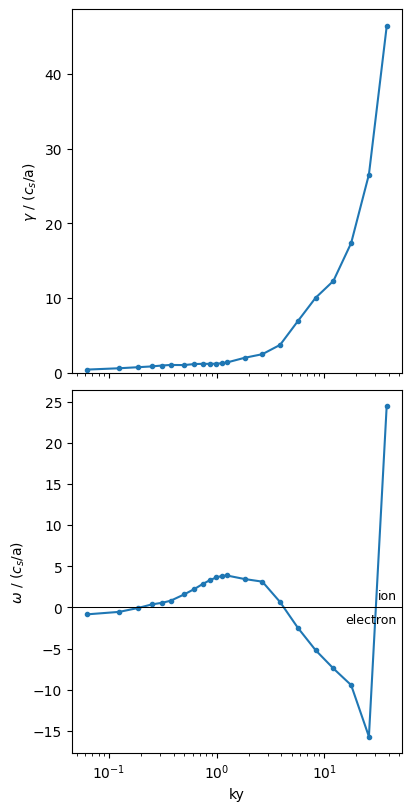

In [7]:
tglf.plot_eigenvalue_spectra(modes=[1],figure=1,show=True)#,save=True,file='eigenvalue_spectra.pdf')